In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.stats import zscore
import matplotlib.pyplot as plt 

In [8]:
df = pd.read_csv('wine.xls', names = ["Cultivator", "Alchol", "Malic_Acid", "Ash", "Alcalinity_of_Ash", "Magnesium", "Total_phenols", "Falvanoids", "Nonflavanoid_phenols", "Proanthocyanins", "Color_intensity", "Hue", "OD280", "Proline"])
df.head()


,Cultivator,Alchol,Malic_Acid,Ash,Alcalinity_of_Ash,Magnesium,Total_phenols,Falvanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
X =  df.drop(['Cultivator'], axis=1)
Y =  df["Cultivator"]
Y

In [4]:
sc=StandardScaler()
X_std=sc.fit_transform(X)

/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [5]:
cov_matrix = np.cov(X_std.T)
#print('Covariance Matrix \n%s', cov_matrix)

In [6]:
cov_matrix.shape

(13, 13)

In [7]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

In [8]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [ 36.1988481   55.40633836  66.52996889  73.59899908  80.16229276
  85.09811607  89.3367954   92.01754435  94.23969775  96.16971684
  97.90655253  99.20478511 100.        ]


In [9]:
eig_vec_sliced=eig_vecs[0:11].transpose()


In [10]:
eig_vec_sliced.shape

(13, 11)

In [11]:
X_std.shape

(178, 13)

In [12]:
x_new=np.dot(X_std,eig_vec_sliced)
x_new.shape

(178, 11)

In [13]:
Dt_model=DecisionTreeClassifier(criterion='gini',random_state=0)#fully grown tree (high bias error and var error)

In [14]:
#Bootstrapped sampled multiple decision tree(with the hope of controlling bias error)
Rf_model = RandomForestClassifier(n_estimators=51,criterion='gini',random_state=0 )

In [15]:
base_knn=KNeighborsClassifier(n_neighbors=3,weights='distance')
LR=LogisticRegression()
NB=GaussianNB()

In [16]:
from sklearn.ensemble import BaggingClassifier
Bagged_DT=BaggingClassifier(n_estimators=51,random_state=0)
Bagged_knn=BaggingClassifier(base_estimator=base_knn,n_estimators=13,random_state=0)
Bagged_LR=BaggingClassifier(base_estimator=LR,n_estimators=51,random_state=0)
Bagged_NB=BaggingClassifier(base_estimator=NB,n_estimators=51,random_state=0)


In [17]:
models = []
models.append(('DecisionTree', Dt_model))
models.append(('RandomForest', Rf_model))
models.append(('Bagged_DT',Bagged_DT))
models.append(('Base_KNN',base_knn))
models.append(('Bagged_KNN',Bagged_knn))
models.append(('Base_LR',LR))
models.append(('Bagged_LR',Bagged_LR))
models.append(('Base_NB',NB))
models.append(('Bagged_NB',Bagged_NB))






In [18]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,shuffle=True,random_state=2)
for model, name in zip([Dt_model , Rf_model, Bagged_DT,LR,Bagged_LR,NB,Bagged_NB], ['DT','RF', 'Bagged_DT','LR','BaggedLR','NB','BaggedNB']):
    k=0
    recall=np.zeros((3,5))
    prec=np.zeros((3,5))
    fscore=np.zeros((3,5))
    for train,test in kf.split(X,Y):
        Xtrain,Xtest=X.iloc[train,:],X.iloc[test,:]
        Ytrain,Ytest=Y[train],Y[test]
        model.fit(Xtrain,Ytrain)
        Y_predict=model.predict(Xtest)
        #acc.append(metrics.accuracy_score(Ytest,Y_predict))
        cm=metrics.confusion_matrix(Ytest,Y_predict)
        for i in np.arange(0,3):
            recall[i,k]=cm[i,i]/cm[i,:].sum()
        for i in np.arange(0,3):
            prec[i,k]=cm[i,i]/cm[:,i].sum()
        k=k+1
    for row in np.arange(0,3):
        for col in np.arange(0,5):
            fscore[row,col]=2*(recall[row,col]*prec[row,col])/(recall[row,col]+prec[row,col])
    print("f1_weighted for class1: %0.02f (+/- %0.5f) [%s]" % (np.mean(fscore[0,:]), np.var(fscore[0,:],ddof=1), name ))   
    print("f1_weighted for class2: %0.02f (+/- %0.5f) [%s]" % (np.mean(fscore[1,:]), np.var(fscore[1,:],ddof=1), name ))   
    print("f1_weighted for class3: %0.02f (+/- %0.5f) [%s]" % (np.mean(fscore[2,:]), np.var(fscore[2,:],ddof=1), name ))   
    

f1_weighted for class1: 0.91 (+/- 0.00224) [DT]
f1_weighted for class2: 0.90 (+/- 0.00212) [DT]
f1_weighted for class3: 0.93 (+/- 0.00673) [DT]
f1_weighted for class1: 0.98 (+/- 0.00037) [RF]
f1_weighted for class2: 0.95 (+/- 0.00202) [RF]
f1_weighted for class3: 0.97 (+/- 0.00294) [RF]
f1_weighted for class1: 0.97 (+/- 0.00117) [Bagged_DT]
f1_weighted for class2: 0.94 (+/- 0.00136) [Bagged_DT]
f1_weighted for class3: 0.96 (+/- 0.00260) [Bagged_DT]
f1_weighted for class1: 0.97 (+/- 0.00101) [LR]
f1_weighted for class2: 0.93 (+/- 0.00303) [LR]
f1_weighted for class3: 0.95 (+/- 0.00294) [LR]
f1_weighted for class1: 0.97 (+/- 0.00101) [BaggedLR]
f1_weighted for class2: 0.94 (+/- 0.00287) [BaggedLR]
f1_weighted for class3: 0.96 (+/- 0.00267) [BaggedLR]
f1_weighted for class1: 0.99 (+/- 0.00037) [NB]
f1_weighted for class2: 0.97 (+/- 0.00112) [NB]
f1_weighted for class3: 0.97 (+/- 0.00312) [NB]
f1_weighted for class1: 0.98 (+/- 0.00037) [BaggedNB]
f1_weighted for class2: 0.96 (+/- 0.00245) 

DecisionTree: 0.220476 (0.018855)
RandomForest: 0.135873 (0.010963)
Bagged_DT: 0.158095 (0.013102)
Base_KNN: 0.123492 (0.009095)
Bagged_KNN: 0.106825 (0.008685)
Base_LR: 0.072857 (0.001771)


/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-package

/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-package

/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda/python3/lib/python3.6/site-package

Bagged_LR: 0.072857 (0.001771)
Base_NB: 0.079048 (0.001829)
Bagged_NB: 0.090476 (0.003080)


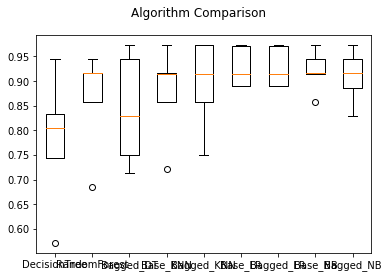

In [37]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5,random_state=2)
	cv_results = model_selection.cross_val_score(model, x_new, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, 1-np.mean(cv_results), np.var(cv_results,ddof=1))
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [196]:
(0.004941-0.004372)/0.004941

0.11515887472171626

In [197]:
(0.099900-0.090376)/0.099900

0.09533533533533538

In [160]:
results

[array([0.90909091, 0.85714286, 0.92307692, 0.94871795, 1.        ]),
 array([0.90909091, 1.        , 0.94871795, 0.94871795, 1.        ]),
 array([0.90909091, 1.        , 0.82051282, 0.92307692, 1.        ])]